In [1]:
import zipfile
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from os.path import join
import glob
import sys
import random
from tqdm import tqdm
import itertools
from itertools import chain
import skimage
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Conv2D, UpSampling2D, Lambda
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

Using TensorFlow backend.


In [70]:
training_path = 'training_data_nuclei/'
test_path = 'test_data_project/'

# Get train and test IDs
train_ids = next(os.walk(training_path))[1]
test_ids = next(os.walk(test_path))[1]

In [3]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [42]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH,1), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = training_path + id_
    img = imread(path + '/images/' + id_ + '.png')
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    if img.ndim>2:
        img=rgb2gray(img)
    img=resize(img,(IMG_HEIGHT,IMG_WIDTH,1))
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        if mask_.ndim>2:
            mask_=rgb2gray(mask_)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

  0%|                                                                                          | 0/111 [00:00<?, ?it/s]

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:12<00:00,  8.70it/s]


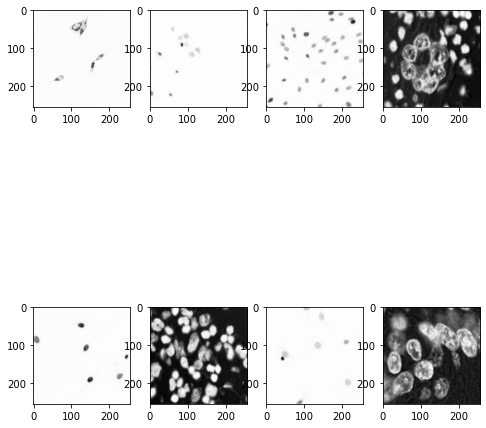

In [43]:
n_row = 2
n_col = 4

plt.figure(figsize=(8,10))

for i in range(8):
  plt.subplot(n_row,n_col,i+1)
  img = X_train[i]
  plt.imshow(img,cmap='Greys')

In [86]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH,1), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
cyto_label = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)
nuclei_label = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = test_path + id_
    img = imread(path + '/images/' + id_ + '.tiff')
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    if img.ndim>2:
        img=rgb2gray(img)
    img=resize(img,(IMG_HEIGHT,IMG_WIDTH,1))
    X_test[n] = img
    
    #**Read labels of test images (only to be used later to calculate the mean IOU)-this is not part of training
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'+'/cyto/'))[2]:
        mask_ = imread(path + '/masks/' +'/cyto/'+ mask_file)
        if mask_.ndim>2:
            mask_=rgb2gray(mask_)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    cyto_label[n] = mask
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'+'/nuclei/'))[2]:
        mask_ = imread(path + '/masks/' +'/nuclei/'+ mask_file)
        if mask_.ndim>2:
            mask_=rgb2gray(mask_)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    nuclei_label[n] = mask
    

 11%|█████████                                                                          | 7/64 [00:00<00:00, 63.72it/s]

Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 52.81it/s]


In [128]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
print('x_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

x_train (88, 256, 256, 1)
x_test (23, 256, 256, 1)
y_train (88, 256, 256, 1)
y_test (23, 256, 256, 1)


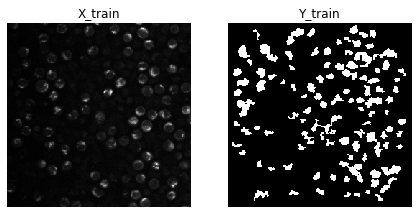

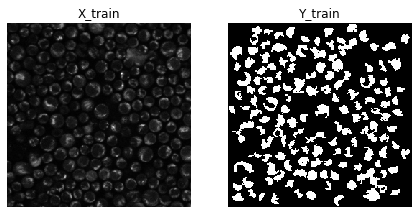

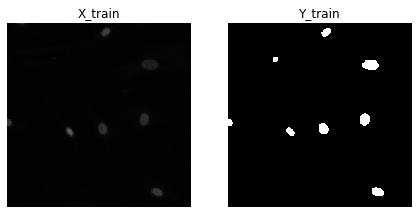

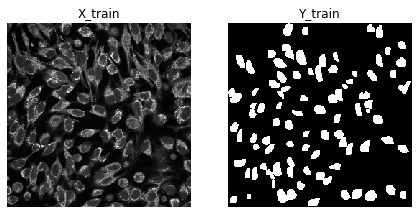

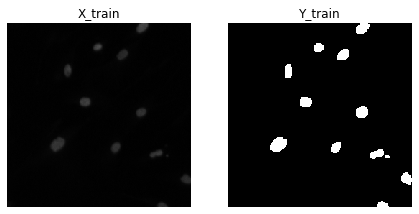

In [129]:
"""
Plotting random 5 training examples and their respective masks
"""
def plotTrainData(a,b):
    for i in range(5):
        ix = random.randint(0, len(train_ids))
        plt.subplot(1,2,1)
        plt.title("X_train")
        imshow(a[ix])
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title("Y_train")
        imshow(np.squeeze(b[ix]))
        plt.axis('off')
        plt.show()
plotTrainData(X_train,Y_train)

In [130]:
"""
Main validation matrix: Intersection over Union

IoU measures the overlap between 2 boundaries. We use that to measure how much our predicted boundary 
overlaps with the ground truth (the real object boundary). In some datasets, we predefine an IoU 
threshold (say 0.5) in classifying whether the prediction is a true positive or a false positive.

"""

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [15]:
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [16]:
def plotPredictions(a,b,c,d,e):
    model = e
    # Threshold predictions
    preds_train = model.predict(a[:int(a.shape[0]*0.9)], verbose=1)
    preds_val = model.predict(a[int(a.shape[0]*0.9):], verbose=1)
    preds_test = model.predict(c, verbose=1)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    # Perform a sanity check on some random training samples
    ix = random.randint(0, len(preds_train_t))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    imshow(a[ix])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    imshow(np.squeeze(b[ix]))
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.axis('off')
    imshow(np.squeeze(preds_train_t[ix]))
    plt.show()
    # Perform a sanity check on some random validation samples
    ix = random.randint(0, len(preds_val_t))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    imshow(a[int(a.shape[0]*0.9):][ix])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    imshow(np.squeeze(b[int(b.shape[0]*0.9):][ix]))
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.axis('off')
    imshow(np.squeeze(preds_val_t[ix]))
    plt.show()

In [17]:
def tweaked_unet():
  inputs = Input((256, 256, 1))
  s = Lambda(lambda x: x / 255) (inputs)

  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
  c1 = Dropout(0.1) (c1)
  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [131]:
model = tweaked_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou,'accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 160         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 256, 16) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [46]:
checkpointer = ModelCheckpoint('model_2_tweaked_unet_checkpointers_nuclei.h5', verbose=1, save_best_only=True)

results = model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=16, epochs=50, callbacks=[checkpointer])

Train on 88 samples, validate on 23 samples
Epoch 1/50
88/88 [==============================] - 3s 34ms/step - loss: 0.2778 - mean_iou: 0.5217 - accuracy: 0.8838 - val_loss: 0.1709 - val_mean_iou: 0.5840 - val_accuracy: 0.9273

Epoch 00001: val_loss improved from inf to 0.17092, saving model to model_2_tweaked_unet_checkpointers_nuclei.h5
Epoch 2/50
88/88 [==============================] - 1s 8ms/step - loss: 0.2179 - mean_iou: 0.5706 - accuracy: 0.9027 - val_loss: 0.1487 - val_mean_iou: 0.5650 - val_accuracy: 0.9337

Epoch 00002: val_loss improved from 0.17092 to 0.14866, saving model to model_2_tweaked_unet_checkpointers_nuclei.h5
Epoch 3/50
88/88 [==============================] - 1s 7ms/step - loss: 0.1921 - mean_iou: 0.5762 - accuracy: 0.9123 - val_loss: 0.1499 - val_mean_iou: 0.5830 - val_accuracy: 0.9370

Epoch 00003: val_loss did not improve from 0.14866
Epoch 4/50
88/88 [==============================] - 1s 8ms/step - loss: 0.1851 - mean_iou: 0.5999 - accuracy: 0.9178 - val_lo

88/88 [==============================] - 1s 8ms/step - loss: 0.1208 - mean_iou: 0.7031 - accuracy: 0.9480 - val_loss: 0.1188 - val_mean_iou: 0.7040 - val_accuracy: 0.9563

Epoch 00033: val_loss did not improve from 0.10665
Epoch 34/50
88/88 [==============================] - 1s 8ms/step - loss: 0.1385 - mean_iou: 0.7052 - accuracy: 0.9410 - val_loss: 0.1083 - val_mean_iou: 0.7054 - val_accuracy: 0.9560

Epoch 00034: val_loss did not improve from 0.10665
Epoch 35/50
88/88 [==============================] - 1s 7ms/step - loss: 0.1418 - mean_iou: 0.7059 - accuracy: 0.9400 - val_loss: 0.1250 - val_mean_iou: 0.7062 - val_accuracy: 0.9465

Epoch 00035: val_loss did not improve from 0.10665
Epoch 36/50
88/88 [==============================] - 1s 8ms/step - loss: 0.1423 - mean_iou: 0.7067 - accuracy: 0.9385 - val_loss: 0.1089 - val_mean_iou: 0.7069 - val_accuracy: 0.9560

Epoch 00036: val_loss did not improve from 0.10665
Epoch 37/50
88/88 [==============================] - 1s 7ms/step - loss:

In [126]:
# Predict on validation
preds_val = model.predict(x_test, verbose=1)
# Threshold predictions
preds_val_t = (preds_val > 0.5)

23/23 [==============================] - 0s 2ms/step


In [48]:
# Define IoU metric as a regular function, to manually check result
def cal_iou(A, B):
    intersection = np.logical_and(A, B)
    union = np.logical_or(A, B)
    iou = np.sum(intersection > 0) / np.sum(union > 0)
    return iou

23/23 [==============================] - 0s 2ms/step


In [49]:
# calcualte average iou of validation images 
iou=[]
for i in range(len(y_test)):
    iou.append(cal_iou(np.squeeze(y_test[i]), np.squeeze(preds_val_t[i])))
print('Average Validate IOU: {}'.format(round(np.mean(iou),2)))

In [171]:
#model = load_model('model_2_tweaked_unet_checkpointers_cyto.h5', custom_objects={'mean_iou': mean_iou})
model = load_model('model_2_tweaked_unet_checkpointers_nuclei.h5', custom_objects={'mean_iou': mean_iou})


In [172]:
predictions = model.predict(X_test,verbose=1)


64/64 [==============================] - 2s 28ms/step


Original Test Image


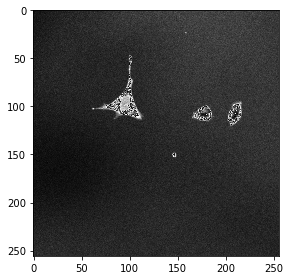

Predicted Test Image Segmented


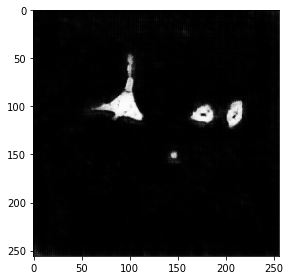

In [157]:
random_int = random.randint(1,50)
print('Original Test Image')
skimage.io.imshow(X_test[5])
plt.show()

print('Predicted Test Image Segmented')
skimage.io.imshow(predictions[5][:,:,0])
plt.show()

In [162]:
#calculate the ioU for the dataset
im1 = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
im2 = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
count=[]
ji=np.zeros(len(predictions))
for n in range(len(predictions)):
    im1=predictions[n][:,:,0]
    im2=np.squeeze(cyto_label[n])
    #im2=np.squeeze(nuclei_label[n])
    ji[n]=cal_iou(im1,im2)
    count.append(n+1)

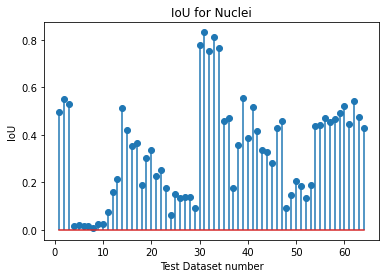

In [163]:
plt.title("IoU for Nuclei") 
plt.xlabel("Test Dataset number") 
plt.ylabel("IoU") 
plt.stem(count,ji) 
plt.show()

In [143]:
np.mean(ji)


0.11828664936549071

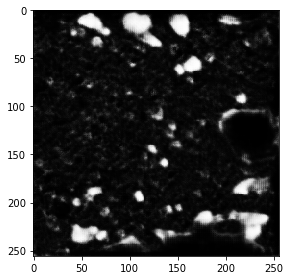

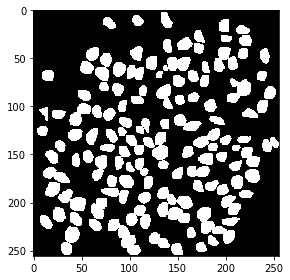

In [175]:
im1=predictions[31][:,:,0]
im2=np.squeeze(nuclei_label[31])
skimage.io.imshow(im1)
plt.show()
skimage.io.imshow(im2)
plt.show()
ji=cal_iou(im1,im2)

In [176]:
ji

0.2965850830078125